### Juan David Orjuela - Sofía Álvarez López

In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
#from keras import regularizers
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None
from tensorflow.keras.layers import Dense 
from scipy.stats import percentileofscore
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

<h1 align='center'>Laboratorio 4: Machine Learning Techniques</h1>

## Problema 2

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

Fuente de Datos: https://www.kaggle.com/mlg-ulb/creditcardfraud


### 2.1 Exploración de los datos

Kaggle nos informa que los datos corresponden a transacciones de tarjeta de crédito hechas durante dos días en Septiembre de 2013 por tarjetahabientes europeos. Es un conjunto altamente desbalanceado, con sólo el 0.172% correspondiente a transacciones fraudulentas. Por motivos de confidencialidad, los datos se han tranformado mediante un PCA (28 componentes), exceptuando "Time" y "Amount", que corresponden al tiempo en segundos entre cada transacción y la primera transacción del set de datos, y al monto de la transacción respectivamente. La variable "Class" es la variable de clasificación, y corresponde a 1 en caso de fraude o a 0 en caso contrario.

Leamos nuestros datos y miremos una muestra aleatoria de 5 transacciones:

In [3]:
df=pd.read_csv("creditcard.csv")
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
205818,135926.0,0.149417,0.436114,0.184035,-1.129537,0.609941,-0.047420,0.583662,0.072732,0.247595,...,0.028403,0.132861,-0.173894,-1.042271,-0.300401,-0.072377,0.045506,0.023414,14.50,0
283217,171449.0,1.401168,-1.085178,-0.695692,1.132043,-1.053430,-0.459309,-0.348068,0.016220,1.451006,...,0.410713,1.092173,-0.199714,0.533233,-0.003971,-0.088648,0.016877,0.020848,250.57,0
12190,21268.0,1.184619,-0.433899,0.979609,-0.547120,-1.101088,-0.341781,-0.836322,0.112086,3.341461,...,-0.146869,0.006881,0.015107,-0.005814,0.346587,-0.691328,0.070982,0.023955,11.85,0
283374,171550.0,2.155090,-0.491147,-2.403430,-1.600528,0.386173,-1.290129,0.504121,-0.488782,1.606957,...,-0.053899,0.082855,-0.144773,-0.946176,0.504118,-0.070836,-0.048682,-0.078263,38.21,0
132143,79872.0,-2.594390,2.233526,0.606646,-1.316492,-0.997506,-0.278482,-1.256509,-2.225221,0.001314,...,3.079027,-1.059769,0.531176,0.388858,-0.271964,0.760471,0.284298,0.124748,1.99,0


Ahora, revisamos si hay algún dato nulo en nuestro conjunto de datos. Notamos que el "máximo" de nulos es 0: es decir, ¡no hay nulos en el conjuntos de datos!

In [4]:
print('Cantidad de nulos:', df.isnull().sum().max())

Cantidad de nulos: 0


Asimismo, revisamos que, en efecto, las clases que hay corresponden a 0 (transacción corriente) y 1 (fraude).

In [5]:
print(f"Las clases presentes en el data set son: {np.unique(df['Class'])}" )

Las clases presentes en el data set son: [0 1]


Ahora, veamos qué tan desbalanceadas están las clases. Esperamos que haya gran desbalance, pues las transacciones fraudulentas son pocas, pero pueden representan pérdidas de millones de dólares anuales.

In [6]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


O, gráficamente, tenemos que:

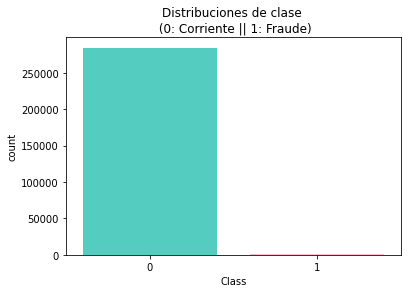

In [7]:
sns.countplot('Class', data=df, palette=['turquoise', 'lightpink'])
plt.title('Distribuciones de clase \n (0: Corriente || 1: Fraude)')
plt.show()

Son tan poquitas transacciones fraudulentas (únicamente el 0.17%) que prácticamente es despreciable en la gráfica de arriba.

Ahora, veamos una descripción estadística de las variables del PCA que se nos ha dado:

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Notamos que la media de casi todos los componentes que provienen del PCA, como esperamos por construcción, es cercana a 0, dado que todos son del orden de $10^{-15}$ y $10^{-16}$. Asimismo, podemos apreciar que la transacción promedio tarda 94.813 ms y el monto promedio por transacción es 88.3 euros. No hay mucha más información que podamos rescatar de esto, pues las 28 variables son las componentes principales del PCA realizado.  

Ahora, veamos si tenemos datos duplicados:

In [9]:
df.duplicated().sum()

1081

Porcentualmente, esto es:

In [10]:
print(np.round(100*df.duplicated().sum()/df.shape[0], 2))

0.38


Y, para la clase positiva,

In [11]:
print(np.round(100*((df["Class"]*df.duplicated()).sum())/df["Class"].sum(), 2))

3.86


Podemos ver que solo el 0.38% de los datos están duplicados, y que 3.86% de los duplicados corresponden a la clase positiva. En realidad, es un porcentaje muy bajo. Debido a que no tenemos el conjunto de datos original, a qué se refiere o cómo se tomaron los datos, es difícil saber si es un error espurio de la adquisición de los datos o si, en efecto, así fueron las transacciones. Por lo tanto, no consideramos pertinente quitar estos datos.

Ahora, veamos las distribuciones (en histogramas) de cada una de las variables que estamos estudiando. 

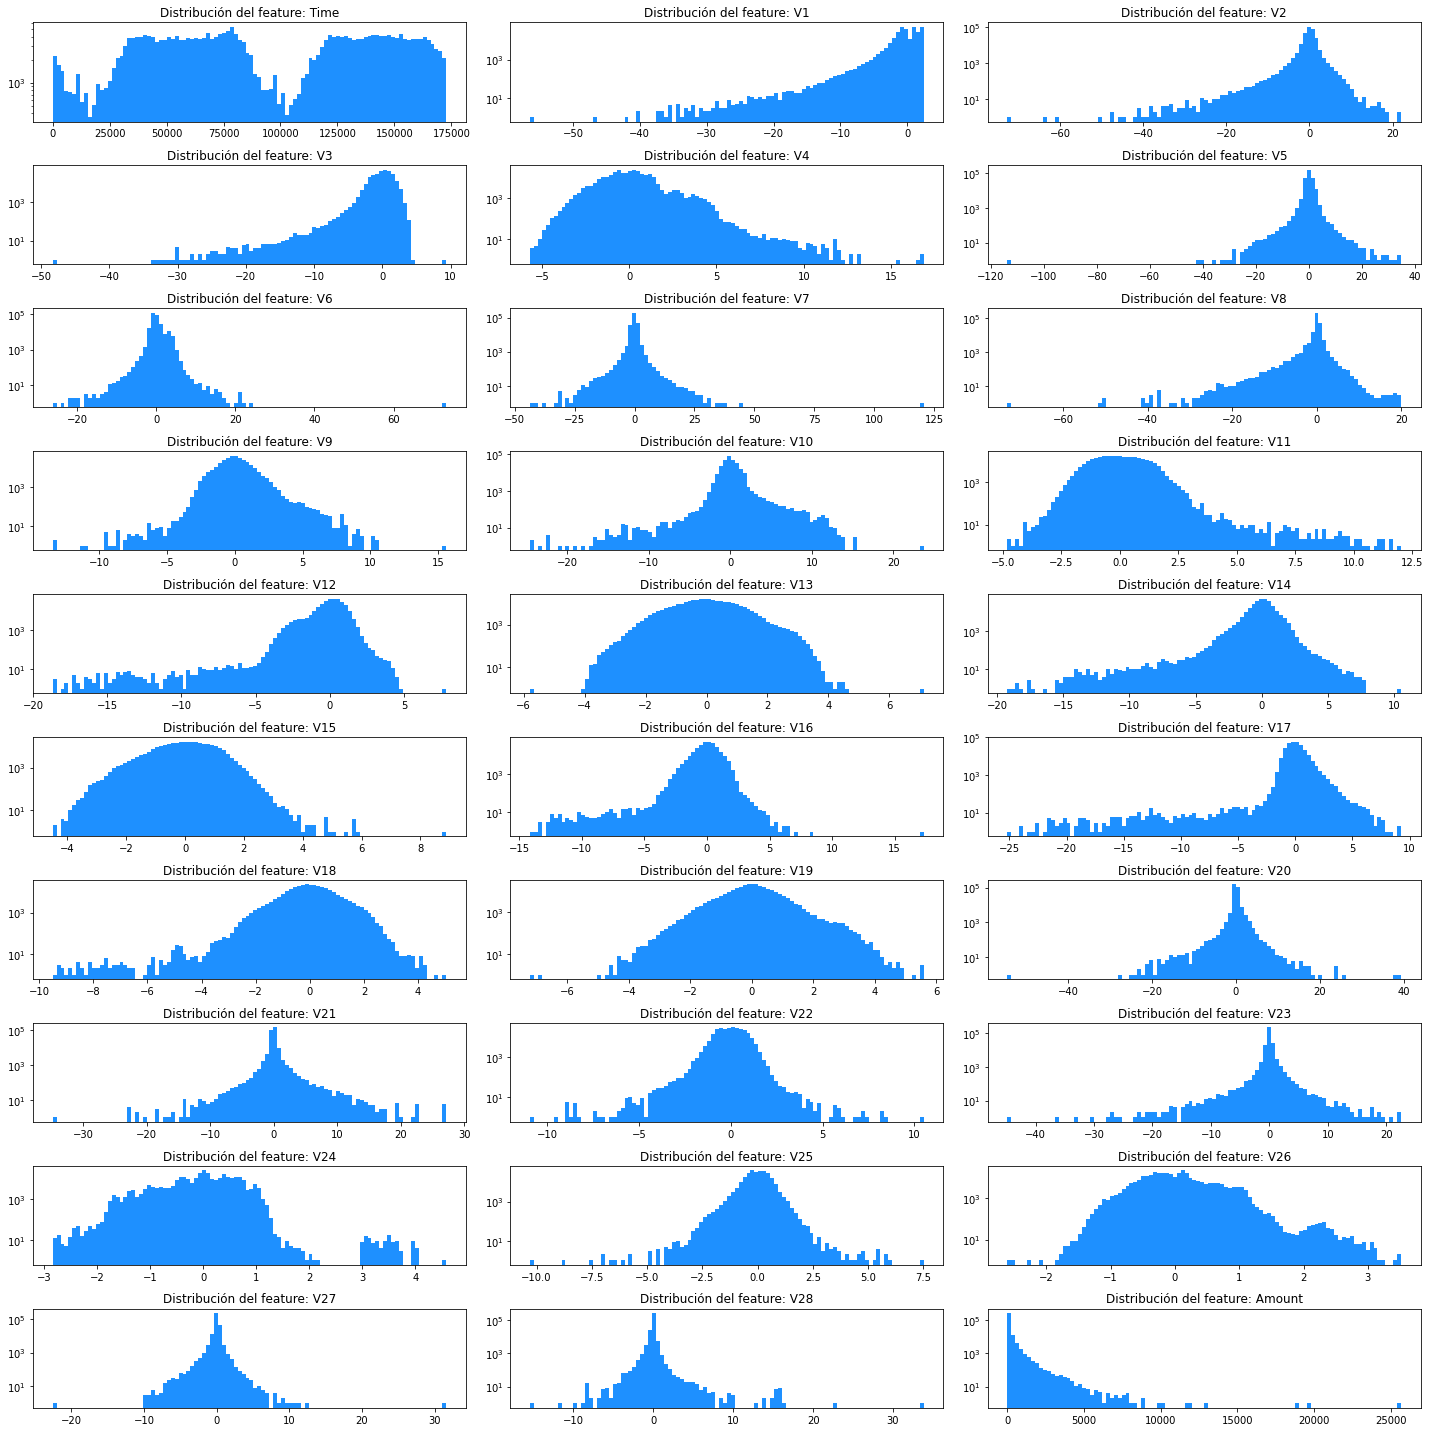

In [12]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=100,ax=ax,facecolor='dodgerblue')
        ax.set_title('Distribución del feature: ' + feature)
        ax.set_yscale('log')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.drop('Class', axis=1).columns,10,3)

Se graficó en escala logarítmica en y para lograr observar los valores pequeños. Para la variable del tiempo se obtiene una distribución correspondiente a una serie de tiempo de periodo de un día. Es altamente probable que los valles correspondan a las horas de la madrugada, cuando se realizan considerablemente menos transacciones. 

Como habíamos dicho previamente, note que todas las ditribuciones están centradas en 0, como es de esperarse.

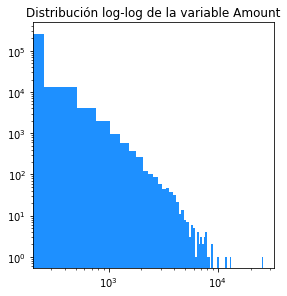

In [13]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
df["Amount"].hist(bins=100,ax=ax,facecolor='dodgerblue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(False)
fig.tight_layout() 
plt.title('Distribución log-log de la variable Amount')
plt.show()

Por el lado del monto, se observa un comportamiento cercano a una ley de potencias (se caracteriza visualmente como una recta en una gráfica log-log), similar a la ley de Zipf o correspondiente con el principio de Pareto, algo que de alguna manera se espera: la mayoría de las transacciones son de montos pequeños y hay muy pocas de montos exorbitantes. Vemos ahora la correlación entre nuestras variables:

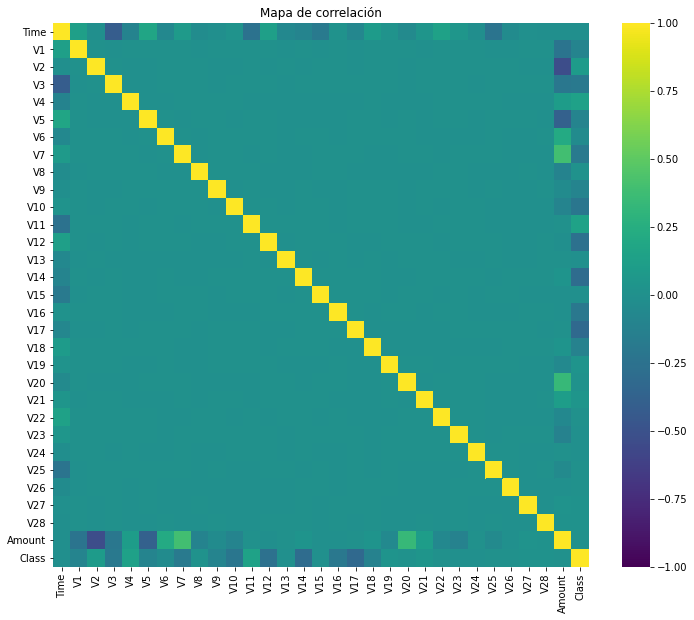

In [14]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr,vmin=-1.0,vmax=1.0,cmap="viridis")
plt.title('Mapa de correlación')
plt.show()

Como es de esperarse, por construcción, la correlación es cercana a cero entre los features del PCA, entonces lo realmente interesante sería observar las otras columnas. Se observa una anticorrelación interesante entre "Amount" y el V2 y un poco el V5 también. También hay una ligera anticorrelación entre "Time" y V3.

Ahora separamos nuestro conjuntos entre fraude y no-fraude y y re-escalamos usando la desviación estándar las variables que no han sido re-escaladas mediante el PCA, es decir las corresponientes a "Time" y "Amount". Luego construimos nuestro primer autoencoder. Procedemos a distribuir los datos de la clase normal entre entrenamiento y validación, y la clase de fraude entre una clase de validación y prueba. 

Usaremos los mismo Callbacks que se aplicaron en el primer problema, a saber "Early Stopping" y "Tensorboard".

### 2.2 Particiones y preprocesamiento
Lo primero que hacemos es separar el target de las features, como vemos a continuación:

In [15]:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

Ahora, separamos los datos entre normal y fraude:

In [16]:
x_normal, x_fraude = x[y == 0], x[y == 1]

Lo siguiente que hacemos es partir el conjunto de datos entre entrenamiento y validación. Como vamos a construir un autoencoder para la reconstrucción de anomalías, lo que debemos hacer es entrenar únicamente con los datos normales. Note que también tomamos un conjunto para realizar la validación de nuestro modelo (i.e. de la reconstrucción de transacciones normales).

No obstante, también partimos el conjunto de fraudes en dos. <code>X_fraude_train</code> lo utilizamos para ver (aún en entrenamiento) si efectivamente se detectan como anomalías las transacciones fraudulentas.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(x_normal, np.ones(len(x_normal)), test_size=0.15, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X_train, np.ones(len(X_train)), test_size=0.2, random_state=28)
X_fraude_train, X_fraude_test, y_fraude_train, y_fraude_test = train_test_split(x_fraude, np.ones(len(x_fraude)), test_size=0.2, random_state=28)

Ahora, seguimos con el preprocesamiento. Lo primero que hacemos es estandarizar (usando un StandardScaler()) las dos variables que no fueron escaladas durante el PCA: Amount y Time.

In [118]:
# Para x_train
X_train['Time'] = StandardScaler().fit_transform(X_train['Time'].values.reshape(-1, 1))
X_train['Amount'] = StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1, 1))
# Para X_fraude_train
X_fraude_train['Time'] = StandardScaler().fit_transform(X_fraude_train['Time'].values.reshape(-1, 1))
X_fraude_train['Amount'] = StandardScaler().fit_transform(X_fraude_train['Amount'].values.reshape(-1, 1))

# Para x_val
X_val['Time'] = StandardScaler().fit_transform(X_val['Time'].values.reshape(-1, 1))
X_val['Amount'] = StandardScaler().fit_transform(X_val['Amount'].values.reshape(-1, 1))

# Los de test los haremos antes de despliegue.

### 2.3 Modelamiento
#### 2.3.1 Primer modelo baseline

Construiremos nuestros autoencoders usando una arquitectura que va reduciendo paulatinamente el número de neuronas, pasando de 30 a 16 y luego a 8 (capa latente), para luego aumentar de nuevo a 16 y 30, cuando reconstruye la entrada. Primeramente exploraremos activación de tangente hiperbólica para las capas ocultas intermedias con activación ReLu para la capa latente y la capa de salida. También probaremos exclusivamente activación ReLu.

In [119]:
input_size = len(X_train.columns)
#Inicializamos el modelo
autoencoder = Sequential(name="Autoencoder_1")

#Encoder
autoencoder.add(Dense(30, activation='tanh', input_dim = input_size)) 
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(8, activation='relu'))

#Decoder
autoencoder.add(Dense(16, activation='tanh'))
autoencoder.add(Dense(30, activation='tanh'))
autoencoder.add(Dense(input_size, activation='relu'))

Ahora compilamos el modelo. Debido a que tenemos un autoencoder (i.e. una tarea de regresión), usamos como función de pérdida el error cuadrático medio. Asimismo, por las mismas razones que justificamos en el problema 1, utilizamos el optimizador Adam. Finalmente, como métrica utilizamos el mismo error cuadrático medio (ya que este usamos como función de pérdida y es una de las mejores métricas en problemas de regresión).

In [120]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Veamos cómo va nuestro modelo:

In [121]:
autoencoder.summary()

Model: "Autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_90 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_91 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_92 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_93 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_94 (Dense)             (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
___________________________________________________

De manera similar al problema 1, definimos y utilizamos los mismos callbacks:

In [122]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None,)
callbacks = [early_stopping,tensorboard_callback]

Ahora sí, hacemos fit a nuestro autoencoder. Tomamos un batch de 1000 (tan grande como sea posible).

In [123]:
history_1 = autoencoder.fit(X_train, X_train, batch_size = 1000, epochs = 100, shuffle = True, callbacks=callbacks)    

Epoch 1/100
194/194 [==============================] - 1s 2ms/step - loss: 0.9113 - mean_squared_error: 0.9113
Epoch 2/100
194/194 [==============================] - 0s 2ms/step - loss: 0.7809 - mean_squared_error: 0.7809
Epoch 3/100
194/194 [==============================] - 0s 2ms/step - loss: 0.7383 - mean_squared_error: 0.7383
Epoch 4/100
194/194 [==============================] - 0s 2ms/step - loss: 0.7152 - mean_squared_error: 0.7152
Epoch 5/100
194/194 [==============================] - 0s 2ms/step - loss: 0.7023 - mean_squared_error: 0.7023
Epoch 6/100
194/194 [==============================] - 0s 2ms/step - loss: 0.6924 - mean_squared_error: 0.6924
Epoch 7/100
194/194 [==============================] - 0s 2ms/step - loss: 0.6860 - mean_squared_error: 0.6860
Epoch 8/100
194/194 [==============================] - 0s 2ms/step - loss: 0.6812 - mean_squared_error: 0.6812
Epoch 9/100
194/194 [==============================] - 0s 2ms/step - loss: 0.6777 - mean_squared_error: 0.6777
E

194/194 [==============================] - 0s 1ms/step - loss: 0.6350 - mean_squared_error: 0.6350
Epoch 75/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6350 - mean_squared_error: 0.6350
Epoch 76/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6347 - mean_squared_error: 0.6347
Epoch 77/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6344 - mean_squared_error: 0.6344
Epoch 78/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6345 - mean_squared_error: 0.6345
Epoch 79/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6345 - mean_squared_error: 0.6345
Epoch 80/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6341 - mean_squared_error: 0.6341
Epoch 81/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6340 - mean_squared_error: 0.6340
Epoch 82/100
194/194 [==============================] - 0s 1ms/step - loss: 0.6341 - mean_squared_error: 0.6341
Epoch

Ya que entrenamos el modelo, podemos ver el error cuadrático medio para cada característica. Para poder visualizar esto, utilizamos el método <code>predict</code> sobre los datos de entrenamiento y validación. Para los de entrenamiento, lo que queremos, en realidad, es la salida de la última capa de la red que acabamos de construir. Los de validación no los ha visto el modelo y nos permitirá ver si se está haciendo overfitting sobre los datos de entrenamiento. 

Asimismo, queremos ver el error cuadrático medio sobre las instancias que queremos clasificar como anómalas (i.e. los fraudes). Estas también las predecimos y les calculamos el error cuadrático medio.

In [124]:
norm_train_recons=autoencoder.predict(X_train)
norm_val_recons=autoencoder.predict(X_val)
fraud_recons=autoencoder.predict(X_fraude_train)

Calculamos el MSE. Esto nos da un dataframe con el MSE para cada feature, para train, validación y los fraudes de entrenamiento.

In [125]:
mse_train = (np.square(norm_train_recons - X_train))
mse_val = (np.square(norm_val_recons - X_val))
mse_fraud = (np.square(fraud_recons - X_fraude_train))

Para observar la capacidad del autoencoder de reconstruir los features, obervamos la distribución del error cuadrático para cada componente. En las gráficas a continuación, los histogramas rosados corresponden a validación, los turquesa a entrenamiento y los azules a fraude.

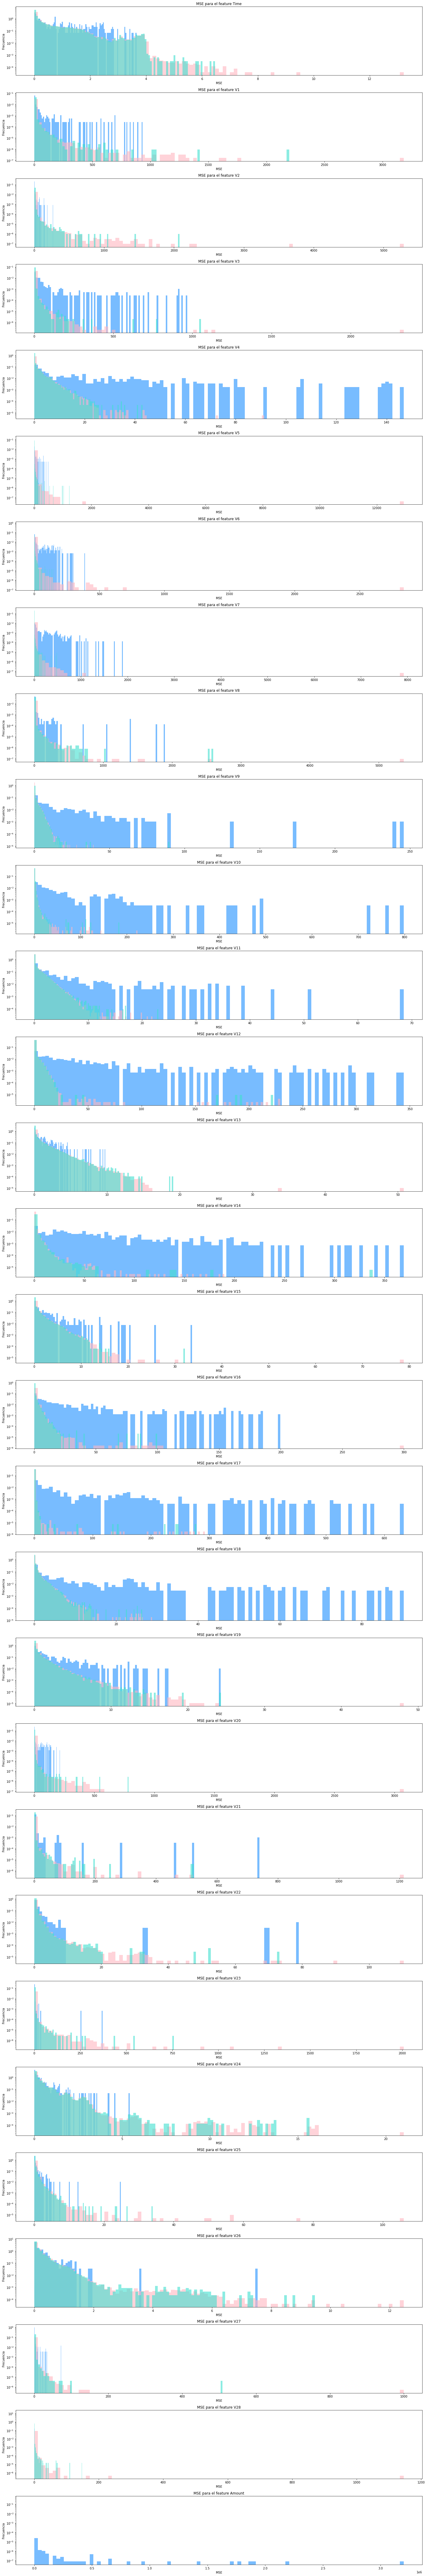

In [126]:
def draw_histograms(dataframe1, dataframe2, dataframe3, features, rows, cols):
    fig=plt.figure(figsize=(20,120))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe3[feature].hist(bins=100,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True)
        dataframe1[feature].hist(bins=100,ax=ax,facecolor='lightpink',alpha=0.6,density=True)
        dataframe2[feature].hist(bins=100,ax=ax,facecolor='turquoise',alpha=0.6,density=True)
        ax.set_title("MSE para el feature " + feature)
        ax.set_yscale('log')
        plt.ylabel('Frecuencia')
        plt.xlabel('MSE')
        ax.grid(False)
    fig.tight_layout()  
    plt.show()

draw_histograms(mse_train, mse_val, mse_fraud, mse_train.columns,30,1)

Vemos que en general pareciera que el autoencoder reconstruye mejor los componentes para la clase de transacciones normales: para la mayoría de features, tanto en entrenamiento como en validación, no sólo los errores obtenidos son similares (como esperamos de una situación de no overfitting) sino que, además, son bajos con respecto a los de transacciones fraudulentas.

Desde aquí podemos ver que, a priori, hay algunas features que ayudan a detectar mejor las transacciones fraudulentas que otras. Esto pues una mayor cantidad de transacciones fraudulentas terminó con errores cuadráticos medios bastante mayores. Estas son: Time, V9, V10, V11, V12, V14, V16, V17, V18 y Amount.

Veamos entonces la distribución del error cuadrático total sobre el conjunto de entrenamiento y validación de la clase mayoritaria y el conjunto de validación de la clase de fraude. El código de color es el mismo de arriba. Rosado para validación (i.e. transacciones corrientes con las que el modelo no fue entrenado), turquesa para entrenamiento y azul para datos fraudulentos.

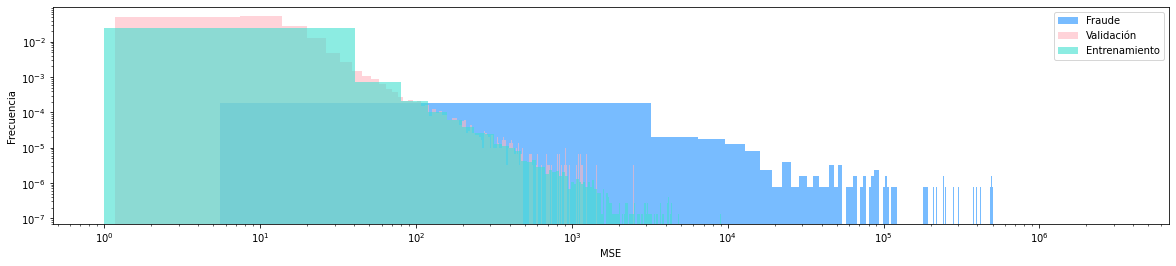

In [127]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,1,1)
mse_fraud.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_val.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_train.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
ax.grid(False)
plt.legend()
plt.show()

Para poder visualizar bien, hacemos una gráfica log-log. Note que, en promedio, los errores asociados a la clase mayoritaria (tanto en entrenamiento como en validación) son bastante pequeños (y siguen la misma tendencia - no estamos haciendo overfitting -) comparados con los de las transacciones fraudulentas. Más aún note que, a partir de cierto valor (aproximadamente $10^2 = 100$), la cantidad de transacciones fraudulentas es mayor que las no fraudulentas. Si determináramos este como nuestro threshold, entonces definitivamente tenemos un gran rango hacia arriba de MSE que nos permite catalogar una transacción como fraudulenta.  

Ahora, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [128]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train[mse_train.sum(axis=1) >= 100])/len(mse_train),2)))

print('En validación: ','{} %'.format(np.round(100*len(mse_val[mse_val.sum(axis=1) >= 100])/len(mse_val),2)))

En entrenamiento:  1.71 %
En validación:  1.66 %


Apenas un 0.06% de diferencia: otro argumento para decir que no está haciendo overfitting.  En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [130]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud[mse_fraud.sum(axis=1) >= 100])/len(mse_fraud),2)))

Fraudulentas:  90.33 %


Vemos que, si definimos el corte en MSE$=100$, el 90.84% de las transacciones fraudulentas se catalogan como tal. Este es un porcentaje bastante bueno, considerando que, además, menos del 2% de las transacciones no fraudulentas se están clasificando como fraudulentas (falsos positivos). 

#### 2.3.2 Segundo modelo baseline
Nuestro segundo modelo baseline considera el uso de funciones de activación ReLu en todas sus capas.

In [40]:
input_size = len(X_train.columns)
#Inicializamos el modelo
autoencoder_2 = Sequential(name="Autoencoder_2")

#Encoder
autoencoder_2.add(Dense(30, activation='relu', input_dim = input_size)) 
autoencoder_2.add(Dense(16, activation='relu'))
autoencoder_2.add(Dense(8, activation='relu'))

#Decoder
autoencoder_2.add(Dense(16, activation='relu'))
autoencoder_2.add(Dense(30, activation='relu'))
autoencoder_2.add(Dense(input_size, activation='relu'))

Escogemos la misma métrica, optimizador y pérdida:

In [41]:
autoencoder_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [42]:
autoencoder_2.summary()

Model: "Autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
Total params: 3,146
Trainable params: 3,146
Non-trainable params: 0
___________________________________________________

Ahora sí, hacemos fit a nuestro autoencoder. Tomamos un batch de 500 (tan grande como sea posible).

In [43]:
history_2 = autoencoder_2.fit(X_train, X_train, batch_size = 500, epochs = 100, shuffle = True, callbacks=callbacks)    

Epoch 1/100
387/387 [==============================] - 1s 1ms/step - loss: 0.8692 - mean_squared_error: 0.8692
Epoch 2/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7628 - mean_squared_error: 0.7628
Epoch 3/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7483 - mean_squared_error: 0.7483
Epoch 4/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7401 - mean_squared_error: 0.7401
Epoch 5/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7349 - mean_squared_error: 0.7349
Epoch 6/100
387/387 [==============================] - 0s 967us/step - loss: 0.7318 - mean_squared_error: 0.7318
Epoch 7/100
387/387 [==============================] - 0s 956us/step - loss: 0.7295 - mean_squared_error: 0.7295
Epoch 8/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7276 - mean_squared_error: 0.7276
Epoch 9/100
387/387 [==============================] - 0s 990us/step - loss: 0.7258 - mean_squared_error: 0.

387/387 [==============================] - 0s 1ms/step - loss: 0.6924 - mean_squared_error: 0.6924
Epoch 74/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6901 - mean_squared_error: 0.6901
Epoch 75/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6889 - mean_squared_error: 0.6889
Epoch 76/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6882 - mean_squared_error: 0.6882
Epoch 77/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6879 - mean_squared_error: 0.6879
Epoch 78/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6875 - mean_squared_error: 0.6875
Epoch 79/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6873 - mean_squared_error: 0.6873
Epoch 80/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6871 - mean_squared_error: 0.6871
Epoch 81/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6868 - mean_squared_error: 0.6868
Epoch

Veamos la distribución del error cuadrático medio para este modelo:

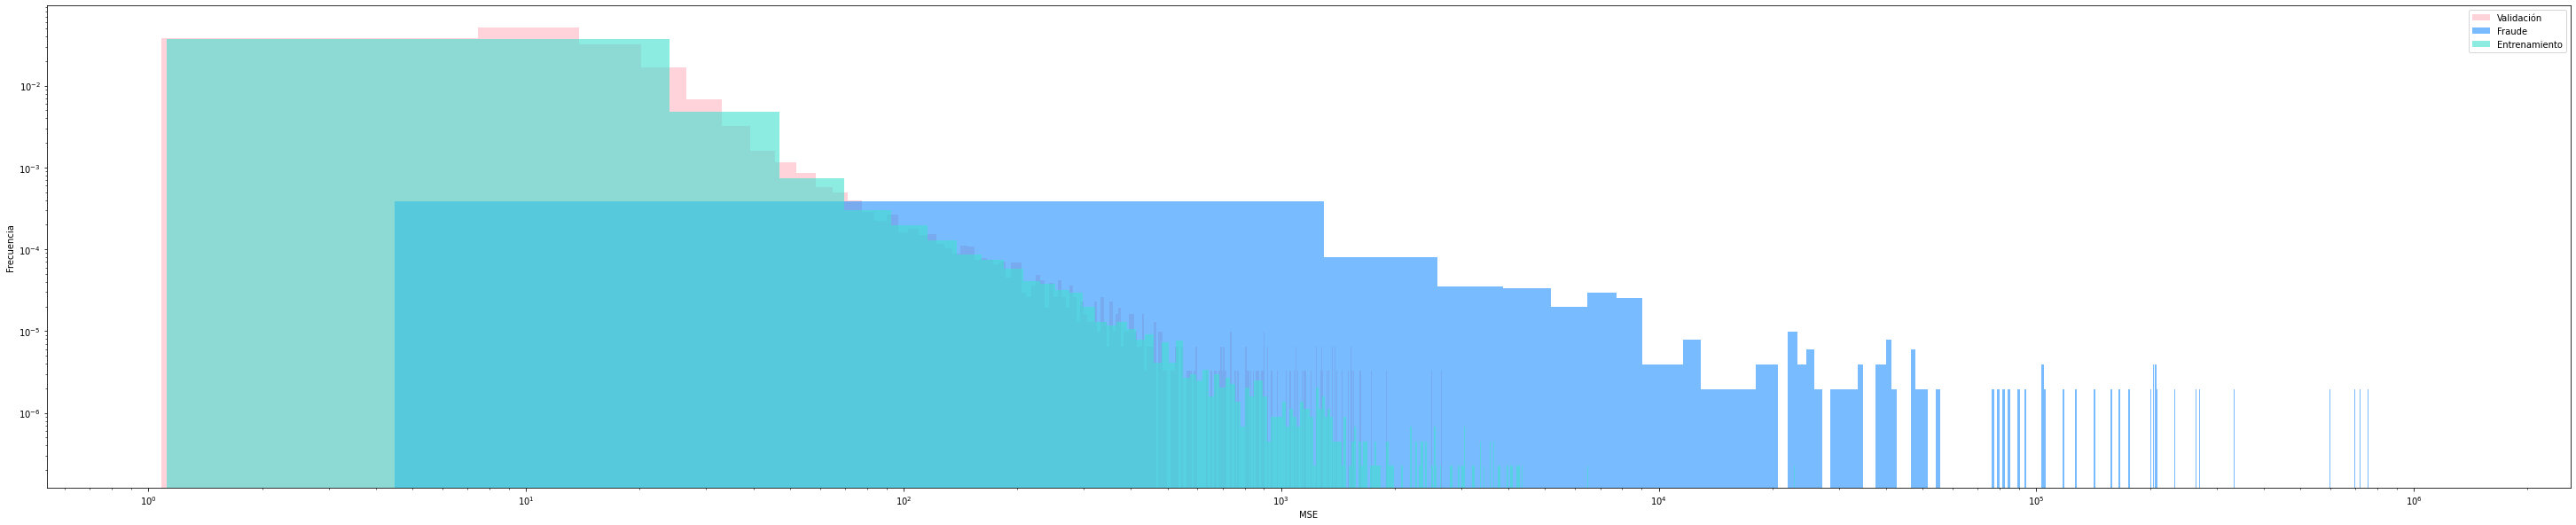

In [44]:
norm_train_recons_2 = autoencoder_2.predict(X_train)
norm_val_recons_2 = autoencoder_2.predict(X_val)
fraud_recons_2 = autoencoder_2.predict(X_fraude_train)

mse_train_2 = (np.square(norm_train_recons_2 - X_train))
mse_val_2 = (np.square(norm_val_recons_2 - X_val))
mse_fraud_2 = (np.square(fraud_recons_2 - X_fraude_train))

fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
mse_val_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_fraud_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_train_2.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
ax.grid(False)
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Podemos ver que, similar al caso anterior, el comportamiento de los datos no fraudulentos en validación (rosado) y entrenamiento (turquesa) es bastante parecido. Asimismo, alrededor de MSE $\approx 100$ podemos ver que la cantidad de transacciones fraudulentas supera las no fraudulentas, similar al primer modelo.

Ahora, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [45]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train_2[mse_train_2.sum(axis=1) >= 100])/len(mse_train_2),2)))

print('En validación: ','{} %'.format(np.round(100*len(mse_val_2[mse_val_2.sum(axis=1) >= 100])/len(mse_val_2),2)))

En entrenamiento:  1.84 %
En validación:  1.76 %


Apenas un 0.07% de diferencia. Confirmamos que no hay overfitting. En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [46]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud_2[mse_fraud_2.sum(axis=1) >= 100])/len(mse_fraud_2),2)))

Fraudulentas:  89.82 %


Vemos que, si definimos MSE$=100$, el 91.1% de las transacciones fraudulentas se catalogan como tal. Este es un porcentaje bastante bueno.

#### 2.3.3 Modelo con ajuste de hiperparámetros
Cuando estábamos creando estos modelos, pensamos mucho en cómo hacer el ajuste de hiperparámetros; pues, en realidad, no hay muchos y los que ajustábamos antes (como cantidad de capas y número de neuronas) son más difíciles de ajustar para un autoencoder. Por lo tanto, decidimos lo siguiente: consideraremos 30 neuronas por capa en la entrada, una segunda capa de 16 y (en algunos casos) una tercera capa de 8 neuronas para el encoder. Quisimos quitar esta última capa en algunos modelos porque quizá estamos reduciendo mucho la dimensionalidad del data set. No quisimos cambiar el número de neuronas por capa por la dimensión del espacio de entrada.

Los otros hiperparámetros que decidimos ajustar fueron las funciones de activación: relu, tanh y sigmoid para las capas interiores de la red, exclusivamente ReLu para la de salida, dado el rango de valores que tiene). Note que la función de activación de las capas del centro siempre es relu. De esta forma:

In [47]:
def entrenar_red(small_layer=True, activation_inside='relu', activation_small='relu',activation_out='relu'):
    input_size = len(X_train.columns) 
    clf = Sequential(name='Autoencoder_CV')
    clf.add(Dense(30, activation=activation_inside, input_dim = input_size))
    if small_layer:
        clf.add(Dense(16, activation=activation_inside))
        clf.add(Dense(8, activation=activation_small))
    else:
        clf.add(Dense(16, activation=activation_small))
        
    clf.add(Dense(16, activation=activation_inside))
    clf.add(Dense(30, activation=activation_inside))
    clf.add(Dense(30, activation=activation_out))
    
    clf.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return clf

# Modelo que utiliza el GridSearch --> Usamos Keras Regressor y no Classifier por ser autoencoder.
modelCV_autoencoder = KerasRegressor(build_fn=entrenar_red, epochs=100, batch_size=500,verbose=1) # Modelo esqueleto

In [48]:
pipe = Pipeline([('autoenconder_CV', modelCV_autoencoder)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  autoenconder_CV__small_layer = [True, False],
                  autoenconder_CV__activation_inside = ['relu', 'tanh','sigmoid']
                  )


# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
# grid_3 = RandomizedSearchCV(pipe_3, param_grid, verbose=3, cv=3, n_iter=20, random_state=28)
grid = GridSearchCV(pipe, param_grid=param_grid,scoring='neg_mean_squared_error',cv=2,verbose=3)

Para la CV, unimos los conjuntos de train y validación:

In [49]:
X_joined = pd.concat([X_train, X_val])

In [50]:
grid.fit(X_joined, X_joined, autoenconder_CV__callbacks=callbacks)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9052 - mean_squared_error: 0.9052
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7604 - mean_squared_error: 0.7604
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7316 - mean_squared_error: 0.7316
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7173 - mean_squared_error: 0.7173
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7049 - mean_squared_error: 0.7049
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6968 - mean_squared_error: 0.6968
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6911 - mean_squared_error: 0.6911
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6869 - mean_squared_error: 0.6869
Epoch 9/100
242/242 [==============================]

242/242 [==============================] - 0s 1ms/step - loss: 0.6509 - mean_squared_error: 0.6509
Epoch 74/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6510 - mean_squared_error: 0.6510
Epoch 75/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6508 - mean_squared_error: 0.6508
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6506 - mean_squared_error: 0.6506
Epoch 77/100
242/242 [==============================] - 0s 957us/step - loss: 0.6505 - mean_squared_error: 0.6505
Epoch 78/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6505 - mean_squared_error: 0.6505
Epoch 79/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6505 - mean_squared_error: 0.6505
Epoch 80/100
242/242 [==============================] - 0s 956us/step - loss: 0.6504 - mean_squared_error: 0.6504
Epoch 81/100
242/242 [==============================] - 0s 932us/step - loss: 0.6503 - mean_squared_error: 0.6503

242/242 [==============================] - 0s 990us/step - loss: 0.6871 - mean_squared_error: 0.6871
Epoch 45/100
242/242 [==============================] - 0s 885us/step - loss: 0.6868 - mean_squared_error: 0.6868
Epoch 46/100
242/242 [==============================] - 0s 909us/step - loss: 0.6861 - mean_squared_error: 0.6861
Epoch 47/100
242/242 [==============================] - 0s 946us/step - loss: 0.6862 - mean_squared_error: 0.6862
Epoch 48/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6858 - mean_squared_error: 0.6858
Epoch 49/100
242/242 [==============================] - 0s 953us/step - loss: 0.6857 - mean_squared_error: 0.6857
Epoch 50/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6856 - mean_squared_error: 0.6856
Epoch 51/100
242/242 [==============================] - 0s 979us/step - loss: 0.6851 - mean_squared_error: 0.6851
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6847 - mean_squared_error: 

242/242 [==============================] - 0s 1ms/step - loss: 0.6224 - mean_squared_error: 0.6224
Epoch 37/100
242/242 [==============================] - 0s 882us/step - loss: 0.6222 - mean_squared_error: 0.6222
Epoch 38/100
242/242 [==============================] - 0s 912us/step - loss: 0.6221 - mean_squared_error: 0.6221
Epoch 39/100
242/242 [==============================] - 0s 953us/step - loss: 0.6220 - mean_squared_error: 0.6220
Epoch 40/100
242/242 [==============================] - 0s 920us/step - loss: 0.6218 - mean_squared_error: 0.6218
Epoch 41/100
242/242 [==============================] - 0s 899us/step - loss: 0.6216 - mean_squared_error: 0.6216
Epoch 42/100
242/242 [==============================] - 0s 916us/step - loss: 0.6214 - mean_squared_error: 0.6214
Epoch 43/100
242/242 [==============================] - 0s 914us/step - loss: 0.6211 - mean_squared_error: 0.6211
Epoch 44/100
242/242 [==============================] - 0s 916us/step - loss: 0.6211 - mean_squared_err

242/242 [==============================] - 0s 902us/step - loss: 0.7136 - mean_squared_error: 0.7136
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7062 - mean_squared_error: 0.7062
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7007 - mean_squared_error: 0.7007
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6970 - mean_squared_error: 0.6970
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6945 - mean_squared_error: 0.6945
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6926 - mean_squared_error: 0.6926
Epoch 12/100
242/242 [==============================] - 0s 916us/step - loss: 0.6912 - mean_squared_error: 0.6912
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6902 - mean_squared_error: 0.6902
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6888 - mean_squared_error: 0.6888
Epoc

242/242 [==============================] - 0s 930us/step - loss: 0.6408 - mean_squared_error: 0.6408
Epoch 79/100
242/242 [==============================] - 0s 911us/step - loss: 0.6413 - mean_squared_error: 0.6413
Epoch 80/100
242/242 [==============================] - 0s 927us/step - loss: 0.6409 - mean_squared_error: 0.6409
Epoch 81/100
242/242 [==============================] - 0s 929us/step - loss: 0.6408 - mean_squared_error: 0.6408
Epoch 00081: early stopping
242/242 [==============================] - 0s 430us/step
[CV 2/2] END autoenconder_CV__activation_inside=relu, autoenconder_CV__small_layer=False;, score=-0.625 total time=  20.7s
Epoch 1/100
242/242 [==============================] - 1s 1ms/step - loss: 0.8894 - mean_squared_error: 0.8894
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7614 - mean_squared_error: 0.7614
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7227 - mean_squared_error: 0.7227
Epoch 4/100
242/

242/242 [==============================] - 0s 1ms/step - loss: 0.6307 - mean_squared_error: 0.6307
Epoch 68/100
242/242 [==============================] - 0s 971us/step - loss: 0.6305 - mean_squared_error: 0.6305
Epoch 69/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6303 - mean_squared_error: 0.6303
Epoch 70/100
242/242 [==============================] - 0s 945us/step - loss: 0.6302 - mean_squared_error: 0.6302
Epoch 71/100
242/242 [==============================] - 0s 944us/step - loss: 0.6301 - mean_squared_error: 0.6301
Epoch 72/100
242/242 [==============================] - 0s 950us/step - loss: 0.6299 - mean_squared_error: 0.6299
Epoch 73/100
242/242 [==============================] - 0s 997us/step - loss: 0.6296 - mean_squared_error: 0.6296
Epoch 74/100
242/242 [==============================] - 0s 973us/step - loss: 0.6295 - mean_squared_error: 0.6295
Epoch 75/100
242/242 [==============================] - 0s 952us/step - loss: 0.6294 - mean_squared_error

242/242 [==============================] - 0s 980us/step - loss: 0.6642 - mean_squared_error: 0.6642
Epoch 38/100
242/242 [==============================] - 0s 967us/step - loss: 0.6620 - mean_squared_error: 0.6620
Epoch 39/100
242/242 [==============================] - 0s 973us/step - loss: 0.6608 - mean_squared_error: 0.6608
Epoch 40/100
242/242 [==============================] - 0s 993us/step - loss: 0.6599 - mean_squared_error: 0.6599
Epoch 41/100
242/242 [==============================] - 0s 985us/step - loss: 0.6592 - mean_squared_error: 0.6592
Epoch 42/100
242/242 [==============================] - 0s 968us/step - loss: 0.6584 - mean_squared_error: 0.6584
Epoch 43/100
242/242 [==============================] - 0s 984us/step - loss: 0.6580 - mean_squared_error: 0.6580
Epoch 44/100
242/242 [==============================] - 0s 994us/step - loss: 0.6572 - mean_squared_error: 0.6572
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6566 - mean_squared_err

242/242 [==============================] - 0s 935us/step - loss: 0.5954 - mean_squared_error: 0.5954
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5944 - mean_squared_error: 0.5944
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5945 - mean_squared_error: 0.5945
Epoch 28/100
242/242 [==============================] - 0s 957us/step - loss: 0.5936 - mean_squared_error: 0.5936
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5931 - mean_squared_error: 0.5931
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5928 - mean_squared_error: 0.5928
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5926 - mean_squared_error: 0.5926
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5922 - mean_squared_error: 0.5922
Epoch 33/100
242/242 [==============================] - 0s 940us/step - loss: 0.5920 - mean_squared_error: 0.5920

Epoch 98/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5831 - mean_squared_error: 0.5831
Epoch 99/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5832 - mean_squared_error: 0.5832
Epoch 100/100
242/242 [==============================] - 1s 2ms/step
[CV 1/2] END autoenconder_CV__activation_inside=tanh, autoenconder_CV__small_layer=False;, score=-0.600 total time=  46.7s
Epoch 1/100
242/242 [==============================] - 2s 4ms/step - loss: 0.8813 - mean_squared_error: 0.8813
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7412 - mean_squared_error: 0.7412
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6997 - mean_squared_error: 0.6997
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6757 - mean_squared_error: 0.6757
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6608 - mean_squared_error: 0.6608
Epoch 6/100
242/242 [========

242/242 [==============================] - 1s 3ms/step - loss: 0.5873 - mean_squared_error: 0.5873
Epoch 70/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5865 - mean_squared_error: 0.5865
Epoch 71/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5865 - mean_squared_error: 0.5865
Epoch 72/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5863 - mean_squared_error: 0.5863
Epoch 73/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5865 - mean_squared_error: 0.5865
Epoch 74/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5861 - mean_squared_error: 0.5861
Epoch 75/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5866 - mean_squared_error: 0.5866
Epoch 76/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5917 - mean_squared_error: 0.5917
Epoch 77/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5875 - mean_squared_error: 0.5875
Epoch

242/242 [==============================] - 1s 2ms/step - loss: 0.8749 - mean_squared_error: 0.8749
Epoch 64/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8749 - mean_squared_error: 0.8749
Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8748 - mean_squared_error: 0.8748
Epoch 66/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8748 - mean_squared_error: 0.8748
Epoch 67/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8748 - mean_squared_error: 0.8748
Epoch 68/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8747 - mean_squared_error: 0.8747
Epoch 69/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8747 - mean_squared_error: 0.8747
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8747 - mean_squared_error: 0.8747
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8746 - mean_squared_error: 0.8746
Epoch

242/242 [==============================] - 1s 4ms/step - loss: 0.8963 - mean_squared_error: 0.8963
Epoch 35/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8954 - mean_squared_error: 0.8954
Epoch 36/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8946 - mean_squared_error: 0.8946
Epoch 37/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8938 - mean_squared_error: 0.8938
Epoch 38/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8931 - mean_squared_error: 0.8931
Epoch 39/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8926 - mean_squared_error: 0.8926
Epoch 40/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8921 - mean_squared_error: 0.8921
Epoch 41/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8916 - mean_squared_error: 0.8916
Epoch 42/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8911 - mean_squared_error: 0.8911
Epoch

242/242 [==============================] - 1s 2ms/step - loss: 0.8584 - mean_squared_error: 0.8584
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8456 - mean_squared_error: 0.8456
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8347 - mean_squared_error: 0.8347
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8276 - mean_squared_error: 0.8276
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8222 - mean_squared_error: 0.8222
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8175 - mean_squared_error: 0.8175
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8132 - mean_squared_error: 0.8132
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8091 - mean_squared_error: 0.8091
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8054 - mean_squared_error: 0.8054
Epoch 14/

242/242 [==============================] - 1s 2ms/step - loss: 0.7574 - mean_squared_error: 0.7574
Epoch 79/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7569 - mean_squared_error: 0.7569
Epoch 80/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7568 - mean_squared_error: 0.7568
Epoch 81/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7567 - mean_squared_error: 0.7567
Epoch 82/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7567 - mean_squared_error: 0.7567
Epoch 83/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7566 - mean_squared_error: 0.7566
Epoch 84/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7565 - mean_squared_error: 0.7565
Epoch 85/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7564 - mean_squared_error: 0.7564
Epoch 86/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7563 - mean_squared_error: 0.7563
Epoch

242/242 [==============================] - 0s 974us/step - loss: 0.8564 - mean_squared_error: 0.8564
Epoch 50/100
242/242 [==============================] - 0s 976us/step - loss: 0.8558 - mean_squared_error: 0.8558
Epoch 51/100
242/242 [==============================] - 0s 966us/step - loss: 0.8554 - mean_squared_error: 0.8554
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8551 - mean_squared_error: 0.8551
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8547 - mean_squared_error: 0.8547
Epoch 54/100
242/242 [==============================] - 0s 966us/step - loss: 0.8546 - mean_squared_error: 0.8546
Epoch 55/100
242/242 [==============================] - 0s 981us/step - loss: 0.8543 - mean_squared_error: 0.8543
Epoch 56/100
242/242 [==============================] - 0s 969us/step - loss: 0.8541 - mean_squared_error: 0.8541
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8538 - mean_squared_error: 

484/484 [==============================] - 0s 933us/step - loss: 0.5922 - mean_squared_error: 0.5922
Epoch 20/100
484/484 [==============================] - 0s 974us/step - loss: 0.5918 - mean_squared_error: 0.5918
Epoch 21/100
484/484 [==============================] - 0s 935us/step - loss: 0.5913 - mean_squared_error: 0.5913
Epoch 22/100
484/484 [==============================] - 0s 927us/step - loss: 0.5908 - mean_squared_error: 0.5908
Epoch 23/100
484/484 [==============================] - 0s 970us/step - loss: 0.5904 - mean_squared_error: 0.5904
Epoch 24/100
484/484 [==============================] - 0s 996us/step - loss: 0.5899 - mean_squared_error: 0.5899
Epoch 25/100
484/484 [==============================] - 0s 988us/step - loss: 0.5895 - mean_squared_error: 0.5895
Epoch 26/100
484/484 [==============================] - 0s 993us/step - loss: 0.5898 - mean_squared_error: 0.5898
Epoch 27/100
484/484 [==============================] - 0s 986us/step - loss: 0.5888 - mean_squared_e

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('autoenconder_CV',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8204821c40>)]),
             param_grid={'autoenconder_CV__activation_inside': ['relu', 'tanh',
                                                                'sigmoid'],
                         'autoenconder_CV__small_layer': [True, False]},
             scoring='neg_mean_squared_error', verbose=3)

Revisamos cuál es el mejor modelo:

In [56]:
best_model_autoencoder = grid.best_estimator_
best_model_autoencoder['autoenconder_CV'].model.summary()

Model: "Autoencoder_CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_79 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_80 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_81 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_82 (Dense)             (None, 30)                930       
Total params: 3,138
Trainable params: 3,138
Non-trainable params: 0
_________________________________________________________________


Veamos las funciones de activación de nuestro problema:

In [65]:
act_layer_1 =best_model_autoencoder['autoenconder_CV'].model.get_layer('dense_78').get_config()['activation']
act_layer_2 =best_model_autoencoder['autoenconder_CV'].model.get_layer('dense_79').get_config()['activation']
act_layer_3 =best_model_autoencoder['autoenconder_CV'].model.get_layer('dense_80').get_config()['activation']
act_layer_4 =best_model_autoencoder['autoenconder_CV'].model.get_layer('dense_81').get_config()['activation']
act_layer_5 =best_model_autoencoder['autoenconder_CV'].model.get_layer('dense_82').get_config()['activation']
print('Las funciones de activación son: {}, {}, {}, {}, {}'.format(act_layer_1, act_layer_2, act_layer_3,act_layer_4,act_layer_5))

Las funciones de activación son: tanh, relu, tanh, tanh, relu


¡Vemos que para las capas intermedias (excepto la de la mitad) escoge tanh!

¡Podemos ver que se eligió el modelo sin la capa de 8 neuronas! Veamos el resultado del MSE

In [66]:
best_score_autoencoder = np.abs(grid.best_score_)
print('El MSE del mejor modelo para el autoencoder es: ', best_score_autoencoder)

El MSE del mejor modelo para el autoencoder es:  0.5872541573687962


De igual forma que para los otros modelos, graficamos el MSE para los datos de entrenamiento y comparamos con los de validación, con el fin de revisar que no haya overfitting (i.e. obteniendo distribuciones similares). Asimismo, revisamos con las transacciones fraudulentas a ver si no se están reconstruyendo bien (i.e. son anómalas).

1/1 [==============================] - 0s 9ms/step


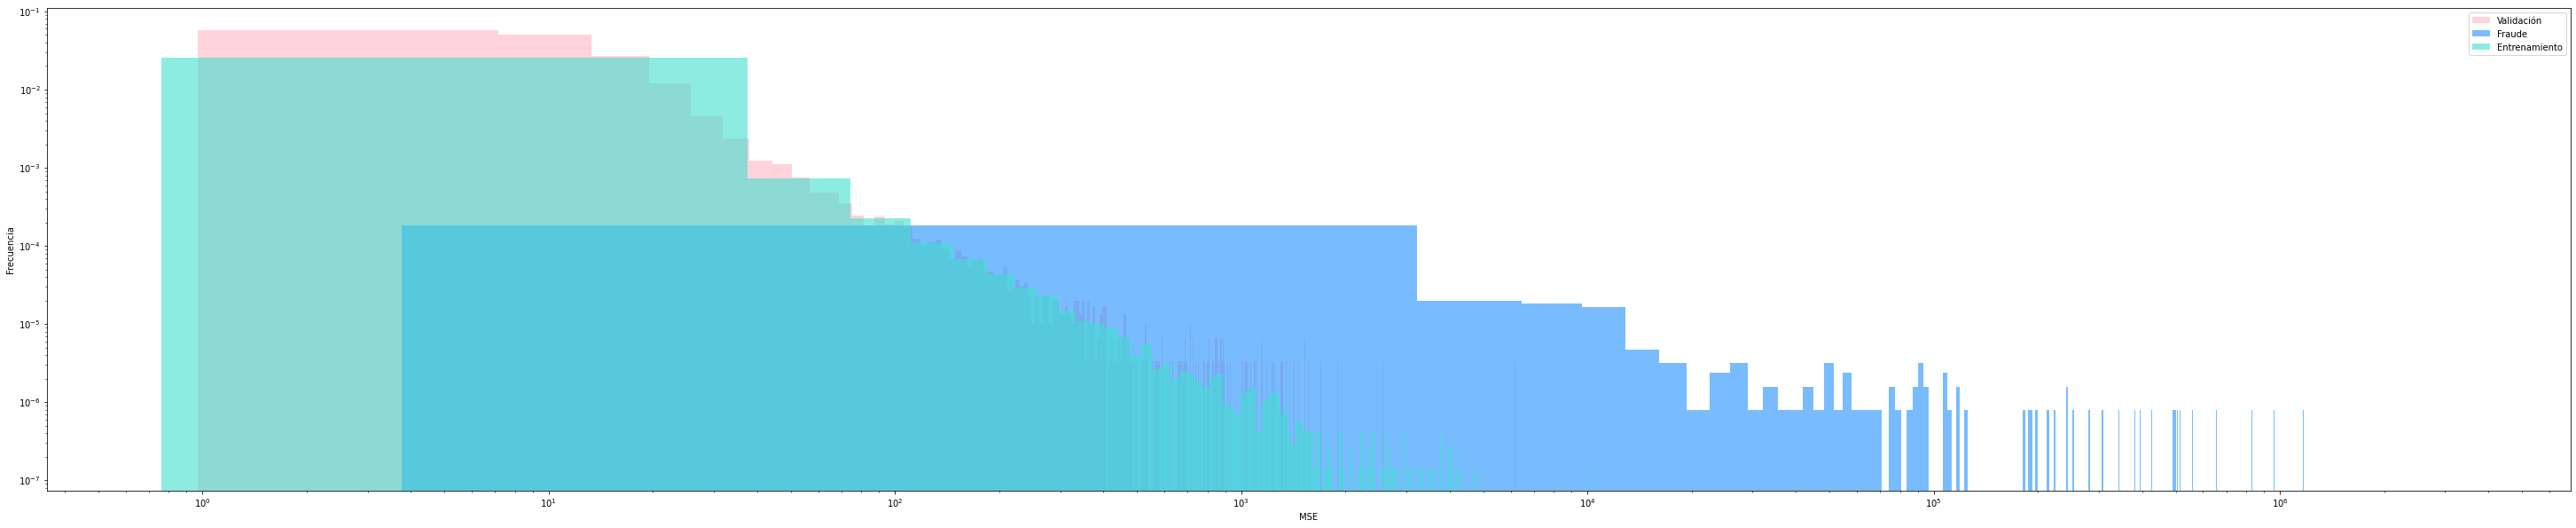

In [67]:
norm_train_recons_3 = best_model_autoencoder.predict(X_train)
norm_val_recons_3 = best_model_autoencoder.predict(X_val)
fraud_recons_3 = best_model_autoencoder.predict(X_fraude_train)

mse_train_3 = (np.square(norm_train_recons_3 - X_train))
mse_val_3 = (np.square(norm_val_recons_3 - X_val))
mse_fraud_3 = (np.square(fraud_recons_3 - X_fraude_train))

fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
mse_val_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Validación')
mse_fraud_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
mse_train_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='turquoise',alpha=0.6,density=True,label='Entrenamiento')
ax.grid(False)
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Podemos ver una tendencia similar a las dos gráficas estudiadas previamente: tanto entrenamiento como validación siguen una tendencia similar en su MSE y la cantidad de transacciones fraudulentas supera a las no fraudulentas alrededor de MSE $\approx100$.

Asimismo, podemos ver que el porcentaje de transacciones no fraudulentas cuyo error cuadrático medio en entrenamiento es mayor a 100 es:

In [79]:
print('En entrenamiento: ','{} %'.format(np.round(100*len(mse_train_3[mse_train_3.sum(axis=1) >= 100])/len(mse_train_3),2)))

En entrenamiento:  1.59 %


In [80]:
print('En validación: ','{} %'.format(np.round(100*len(mse_val_3[mse_val_3.sum(axis=1) >= 100])/len(mse_val_3),2)))

En validación:  1.56 %


¡Apenas un 0.03% de diferencia! En cambio, el porcentaje de transacciones fraudulentas con MSE mayor a 100 es:

In [81]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud_3[mse_fraud_3.sum(axis=1) >= 100])/len(mse_fraud_3),2)))

Fraudulentas:  89.57 %


El 89.57% de las transacciones fraudulentas se cataloga como tal si definimos el threshold en MSE$ = 100$. Esto es un número bastante bueno. Podemos incluso aumentarlo si disminuimos un poco el MSE, considerando que apenas $\approx 1.6$% de las transacciones no fraudulentas se catalogan como fraudulentas.

#### 2.3.4 Definición de los thresholds y escogencia del modelo

Podemos redefinir el threshold de MSE=$100$, a aproximadamente el 2% de las transacciones no fraudulentas catalogadas como fraudulentas. Con esta nueva métrica, tenemos MSE$ \geq82$ para que una transacción sea categorizada como fraudulenta. De esta forma, tenemos que los porcentajes de transacciones fraudulentas catalogadas adecuadamente son:

In [145]:
print('Nuevo MSE threshold:', np.percentile(mse_train_3.sum(axis=1),100-2, interpolation="linear"))

Nuevo MSE threshold: 82.07755644150028


In [71]:
print('Modelo baseline 1: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud.sum(axis=1), np.percentile(mse_train.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo baseline 1:  90.59 %


In [72]:
print('Modelo baseline 2: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud_2.sum(axis=1), np.percentile(mse_train_2.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo baseline 2:  89.82 %


In [73]:
print('Modelo con CV: ', '{} %'.format(np.round(100 - percentileofscore(mse_fraud_3.sum(axis=1), np.percentile(mse_train_3.sum(axis=1),98, interpolation="linear"), kind="mean"),2))) 

Modelo con CV:  90.59 %


En general, podemos ver que los tres porcentajes obtenidos son bastante similares. De hecho, el performance reportado por el modelo baseline tiene exactamente los mismos números que el encontrado en la búsqueda exhaustiva del CV y búsqueda de hiperparámetros (aunque ese modelo está dentro de esa búsqueda). Así las cosas, y dado que el modelo del CV tiene más peso estadístico, elegimos ese para el despliegue.

### 2.4 Despliegue del modelo

Recordemos que el test es únicamente de transacciones fraudulentas. ¡Veamos qué tan bien quedaron clasificadas! Antes de eso, debemos escalar las variables de Amount y Time con el <code>StandardScaler()</code>, como hicimos en entrenamiento y validación.

In [150]:
# Para X_fraude_test
X_fraude_test['Time'] = StandardScaler().fit_transform(X_fraude_test['Time'].values.reshape(-1, 1))
# X_fraude_test['Amount'] = StandardScaler().fit_transform(X_fraude_test['Amount'].values.reshape(-1, 1))

# Para x_test
X_test['Time'] = StandardScaler().fit_transform(X_test['Time'].values.reshape(-1, 1))
X_test['Amount'] = StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1, 1))

Ahora predecimos con nuestro modelo de Cross Validation:

In [151]:
norm_test_recons = best_model_autoencoder.predict(X_test)
fraud_recons = best_model_autoencoder.predict(X_fraude_test)

mse_test = (np.square(norm_test_recons - X_test))
mse_fraud = (np.square(fraud_recons - X_fraude_test))

1/1 [==============================] - 0s 12ms/step


Graficamos entonces los resultados:

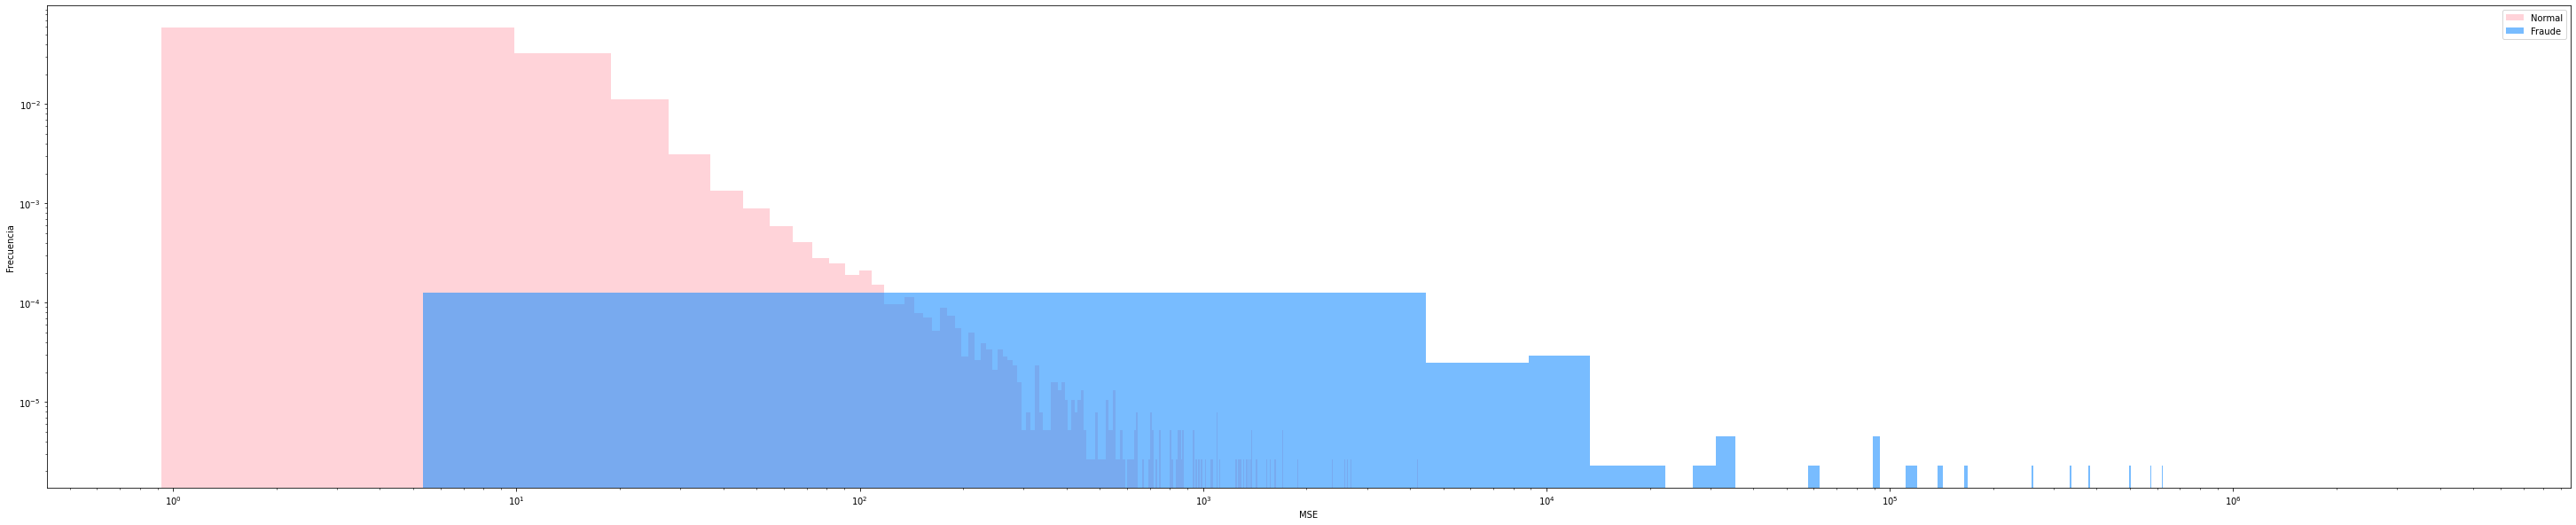

In [152]:
fig=plt.figure(figsize=(51,10))
ax=fig.add_subplot(1,1,1)
mse_test.sum(axis=1).hist(bins=1000,ax=ax,facecolor='lightpink',alpha=0.6,density=True,label='Normal')
mse_fraud.sum(axis=1).hist(bins=1000,ax=ax,facecolor='dodgerblue',alpha=0.6,density=True,label='Fraude')
#mse_fraud_3.sum(axis=1).hist(bins=1000,ax=ax,facecolor='red',alpha=0.6,density=True,label='Fraude')
ax.grid(False)
plt.ylabel('Frecuencia')
plt.xlabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Previamente, habíamos definido que catalogamos una transacción como fraudulenta si MSE$ \geq 82$. Entonces, tomando la misma métrica, tenemos que el porcentaje de transacciones fraudulentas bien categorizadas es:

In [153]:
print('Fraudulentas: ','{} %'.format(np.round(100*len(mse_fraud[mse_fraud.sum(axis=1) >= 82])/len(mse_fraud),2)))

Fraudulentas:  89.9 %


In [163]:
print('Porcentaje de fraudulentas: {} %'.format(np.round(0.101*len(fraud_recons), 2)))

Porcentaje de fraudulentas: 10.0 %


Al permitir que hasta el 2% de las transacciones genuinas sean catalogadas erróneamente como fraudulentas (correspondiente a un error cuadrático total de aproximadamente 82), nuestro modelo tiene finalmente la capacidad de capturar el 89.9% de las transacciones fraudulentas, muy en línea con los resultados reportados en la etapa de validación.

Vemos que solamente el 10% de las transacciones fraudulentas son categorizadas como transacciones normales, lo cual es un porcentaje bastante tolerable para este problema.